In [29]:
import mlflow
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
from yaml.loader import SafeLoader
import glob
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import plot_confusion_matrix

from matplotlib.pyplot import imread
from tensorflow.math import confusion_matrix

# CNN - load model & build classification report

In [7]:
def load_model():
    """
    load the latest saved model, return None if no model found
    """
    stage = "Production"
    model = None
    mlflow.set_tracking_uri('https://mlflow.lewagon.ai')
    model_uri = f"models:/{'deepdraw-model'}/{stage}"
    model = mlflow.keras.load_model(model_uri=model_uri)
    return model

In [8]:
model = load_model()

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

Drawdeep of CNN

In [10]:
layer = model.layers
layer

In [11]:
first_convolution_layer = layer[0]

print(f"- Dimension of the first convolution neutral : {first_convolution_layer.weights[0].shape}")
print(f"- Output of the first convolution neutral : {first_convolution_layer.output[0]}")

- Dimension of the first convolution neutral : (3, 3, 1, 16)
- Output of the first convolution neutral : KerasTensor(type_spec=TensorSpec(shape=(26, 26, 16), dtype=tf.float32, name=None), name='tf.__operators__.getitem/strided_slice:0', description="created by layer 'tf.__operators__.getitem'")


In [12]:
3*3*1*16+16

160

In [13]:
second_convolution_layer = layer[2]

print(f"- Dimension of the first convolution neutral : {second_convolution_layer.weights[0].shape}")
print(f"- Output of the first convolution neutral : {second_convolution_layer.output[0]}")

- Dimension of the first convolution neutral : (3, 3, 16, 32)
- Output of the first convolution neutral : KerasTensor(type_spec=TensorSpec(shape=(13, 13, 32), dtype=tf.float32, name=None), name='tf.__operators__.getitem_1/strided_slice:0', description="created by layer 'tf.__operators__.getitem_1'")


In [14]:
second_convolution_layer.weights[0].shape

TensorShape([3, 3, 16, 32])

In [15]:
second_convolution_layer.output

<KerasTensor: shape=(None, 13, 13, 32) dtype=float32 (created by layer 'conv2d_1')>

In [16]:
3*3*16*32+32

4640

In [17]:
third_convolution_layer = model.layers[4]
print(third_convolution_layer)
print(third_convolution_layer.weights[0].shape)

(3, 3, 32, 64)


In [18]:
third_convolution_layer.output

<KerasTensor: shape=(None, 6, 6, 64) dtype=float32 (created by layer 'conv2d_2')>

In [19]:
3*3*32*64+64

18496

In [36]:
def parse_tfr_element(element):
    #use the same structure as above; it's kinda an outline of the structure we now want to create
    data = {
      'height': tf.io.FixedLenFeature([], tf.int64),
      'width':tf.io.FixedLenFeature([], tf.int64),
      'label':tf.io.FixedLenFeature([], tf.int64),
      'raw_image' : tf.io.FixedLenFeature([], tf.string),
      'depth':tf.io.FixedLenFeature([], tf.int64),
    }

    content = tf.io.parse_single_example(element, data)

    height = content['height']
    width = content['width']
    depth = content['depth']
    label = content['label']
    raw_image = content['raw_image']

    #get our 'feature'-- our image -- and reshape it appropriately
    feature = tf.io.parse_tensor(raw_image, out_type=tf.int64)
    feature = tf.reshape(feature, shape=[height,width,depth])
    return (feature, label)

In [38]:
def get_dataset_multi(tfr_dir: str = "/content/", pattern: str = "*.tfrecords"):
    files = glob.glob(os.path.join(tfr_dir, pattern), recursive=False)
    #print(files)

    #create the dataset
    dataset = tf.data.TFRecordDataset(files)

    #pass every single feature through our mapping function
    dataset = dataset.map(parse_tfr_element)
    return dataset

def load_tfrecords_dataset(source_type = 'train', batch_size=32):
    dataset = get_dataset_multi(tfr_dir='../raw_data/tfrecords/', pattern=f"*_{source_type}.tfrecords")
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda x, y:(tf.cast(x, tf.float32)/255.0, y))
    return dataset

In [30]:
path_yaml= "/Users/hugofraidenraich/code/Sythak/deepdraw/deep_draw/dl_logic/categories.yaml"
# Open the file and load the file
with open(path_yaml) as f:
    class_names = yaml.load(f, Loader=SafeLoader)

In [31]:
class_names

['angel',
 'ant',
 'axe',
 'basketball',
 'bathtub',
 'bear',
 'bed',
 'brain',
 'bridge',
 'cactus',
 'calculator',
 'camel',
 'camera',
 'car',
 'carrot',
 'castle',
 'cat',
 'church',
 'circle',
 'cloud',
 'coffee cup',
 'couch',
 'cow',
 'crayon',
 'crocodile',
 'crown',
 'diamond',
 'dog',
 'dolphin',
 'door',
 'elephant',
 'eye',
 'fish',
 'flamingo',
 'flower',
 'fork',
 'frog',
 'giraffe',
 'guitar',
 'hamburger',
 'hammer',
 'hand',
 'harp',
 'hat',
 'hedgehog',
 'helicopter',
 'horse',
 'leaf',
 'line',
 'lion',
 'lobster',
 'mailbox',
 'matches',
 'motorbike',
 'mountain',
 'mouse',
 'mouth',
 'mushroom',
 'pants',
 'paper clip',
 'parachute',
 'pear',
 'peas',
 'pig',
 'pineapple',
 'pizza',
 'rabbit',
 'rain',
 'rainbow',
 'river',
 'roller coaster',
 'scorpion',
 'shoe',
 'skull',
 'snail',
 'snake',
 'snowflake',
 'spider',
 'spoon',
 'square',
 'stairs',
 'star',
 'stethoscope',
 'strawberry',
 'sun',
 'sword',
 't-shirt',
 'table',
 'telephone',
 'television',
 'tiger'

In [36]:
dataset_test = load_tfrecords_dataset(source_type = 'test', batch_size=32)

In [39]:
for e in dataset_test.take(2):
    print(e)

(<tf.Tensor: shape=(32, 28, 28, 1), dtype=float32, numpy=
array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.01568628],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


  

In [41]:
y_pred = model.predict(dataset_test)
print(f"shape of y_pred : {y_pred.shape}")

18750/18750 [==============================] - 108s 6ms/step


In [52]:
y_pred

array([[2.6070413e-06, 6.3082337e-07, 3.0834814e-05, ..., 1.1211926e-07,
        2.7167507e-08, 5.5407812e-10],
       [5.1313814e-10, 2.1694176e-10, 6.3951546e-09, ..., 1.0046450e-09,
        1.3737318e-09, 1.5188333e-07],
       [8.7949127e-01, 6.8183220e-04, 9.2791313e-05, ..., 4.1245876e-04,
        3.0071783e-04, 1.3789521e-04],
       ...,
       [6.5564315e-08, 4.2882807e-08, 3.5146563e-08, ..., 3.2013034e-08,
        1.4315184e-18, 6.3220634e-10],
       [4.7095548e-04, 9.0225972e-04, 5.6863385e-03, ..., 1.5647680e-03,
        5.5538281e-04, 5.6821322e-03],
       [1.8866685e-07, 1.7277267e-09, 3.4632147e-05, ..., 5.3599009e-13,
        3.3557828e-18, 5.0403487e-06]], dtype=float32)

In [55]:
class Estimator:
    _estimator_type = ''
    classes_=[]
    def __init__(self, model, classes):
        self.model = model
        self._estimator_type = 'classifier'
        self.classes_ = classes
    def predict(self, X):
        y_prob= self.model.predict(X)
        y_pred = y_prob.argmax(axis=1)
        return y_pred

classifier = Estimator(model, class_names)

In [68]:
y = np.concatenate([y for x, y in dataset_test], axis=0)
x = np.concatenate([x for x, y in dataset_test], axis=0)

In [70]:
y

array([58, 89,  0, ..., 82, 70, 86])

In [73]:
pred_y = np.argmax(y_pred, 1)

In [74]:
pred_y

array([58, 89,  0, ..., 82, 70, 86])

In [71]:
x

array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.01568628],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.        ],
         [0.        ],
         [0.  

   10/18750 [..............................] - ETA: 1:46 

/Users/hugofraidenraich/.pyenv/versions/3.10.6/envs/deepdraw/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


18750/18750 [==============================] - 108s 6ms/step


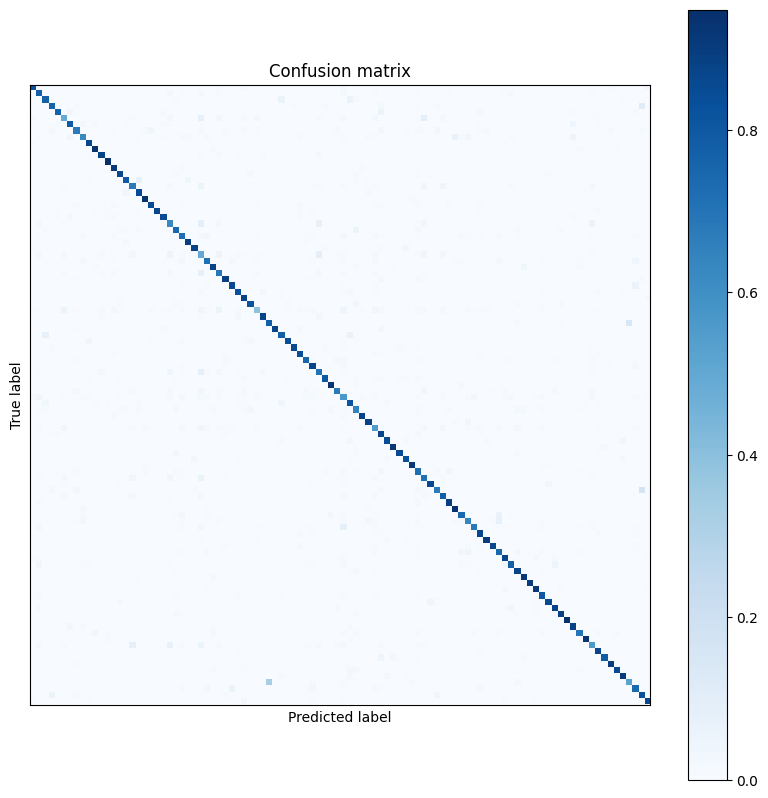

In [109]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(estimator= classifier, X=x, y_true=y, cmap='Blues',normalize='true', include_values=False, ax=ax)
plt.title('Confusion matrix')
plt.tick_params(left = False)
plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)

In [81]:
#test_cat = np.argmax(test_y, 1)
#pred_y = model.predict(test_X, batch_size = 4096)
#pred_cat = np.argmax(pred_y, 1)

In [80]:
print(classification_report(y, pred_y, target_names = class_names))

                precision    recall  f1-score   support

         angel       0.87      0.82      0.84      5936
           ant       0.70      0.77      0.73      6037
           axe       0.74      0.77      0.75      5942
    basketball       0.81      0.76      0.78      6047
       bathtub       0.87      0.76      0.81      5910
          bear       0.65      0.49      0.56      5991
           bed       0.80      0.79      0.80      5901
         brain       0.70      0.68      0.69      5856
        bridge       0.72      0.63      0.67      6026
        cactus       0.82      0.86      0.84      6148
    calculator       0.88      0.94      0.91      6085
         camel       0.85      0.87      0.86      5960
        camera       0.89      0.95      0.92      6010
           car       0.82      0.91      0.86      5940
        carrot       0.87      0.86      0.87      5982
        castle       0.83      0.79      0.81      5924
           cat       0.73      0.68      0.70  

In [110]:
class_names

['angel',
 'ant',
 'axe',
 'basketball',
 'bathtub',
 'bear',
 'bed',
 'brain',
 'bridge',
 'cactus',
 'calculator',
 'camel',
 'camera',
 'car',
 'carrot',
 'castle',
 'cat',
 'church',
 'circle',
 'cloud',
 'coffee cup',
 'couch',
 'cow',
 'crayon',
 'crocodile',
 'crown',
 'diamond',
 'dog',
 'dolphin',
 'door',
 'elephant',
 'eye',
 'fish',
 'flamingo',
 'flower',
 'fork',
 'frog',
 'giraffe',
 'guitar',
 'hamburger',
 'hammer',
 'hand',
 'harp',
 'hat',
 'hedgehog',
 'helicopter',
 'horse',
 'leaf',
 'line',
 'lion',
 'lobster',
 'mailbox',
 'matches',
 'motorbike',
 'mountain',
 'mouse',
 'mouth',
 'mushroom',
 'pants',
 'paper clip',
 'parachute',
 'pear',
 'peas',
 'pig',
 'pineapple',
 'pizza',
 'rabbit',
 'rain',
 'rainbow',
 'river',
 'roller coaster',
 'scorpion',
 'shoe',
 'skull',
 'snail',
 'snake',
 'snowflake',
 'spider',
 'spoon',
 'square',
 'stairs',
 'star',
 'stethoscope',
 'strawberry',
 'sun',
 'sword',
 't-shirt',
 'table',
 'telephone',
 'television',
 'tiger'

# CNN - show convolution filters

In [197]:
cats = np.load('/Users/jean-baptiste/code/Sythak/deepdraw/raw_data/npy/full_numpy_bitmap_cat.npy')
cat1 = cats[0].reshape(28, 28, 1)

pigs = np.load('/Users/jean-baptiste/code/Sythak/deepdraw/raw_data/npy/full_numpy_bitmap_pig.npy')
pig2 = pigs[1].reshape(28, 28, 1)

frogs = np.load('/Users/jean-baptiste/code/Sythak/deepdraw/raw_data/npy/full_numpy_bitmap_frog.npy')
frog5 = frogs[4].reshape(28, 28, 1)

hats = np.load('/Users/jean-baptiste/code/Sythak/deepdraw/raw_data/npy/full_numpy_bitmap_hat.npy')
hat1 = hats[1].reshape(28, 28, 1)

eyes = np.load('/Users/jean-baptiste/code/Sythak/deepdraw/raw_data/npy/full_numpy_bitmap_eye.npy')
eye1 = eyes[0].reshape(28, 28, 1)

bears = np.load('/Users/jean-baptiste/code/Sythak/deepdraw/raw_data/npy/full_numpy_bitmap_bear.npy')
bear9 = bears[8].reshape(28, 28, 1)

guitars = np.load('/Users/jean-baptiste/code/Sythak/deepdraw/raw_data/npy/full_numpy_bitmap_guitar.npy')
guitar1 = guitars[1].reshape(28, 28, 1)

cars = np.load('/Users/jean-baptiste/code/Sythak/deepdraw/raw_data/npy/full_numpy_bitmap_car.npy')
car1 = cars[0].reshape(28, 28, 1)

crowns = np.load('/Users/jean-baptiste/code/Sythak/deepdraw/raw_data/npy/full_numpy_bitmap_crown.npy')
crown4 = crowns[3].reshape(28, 28, 1)

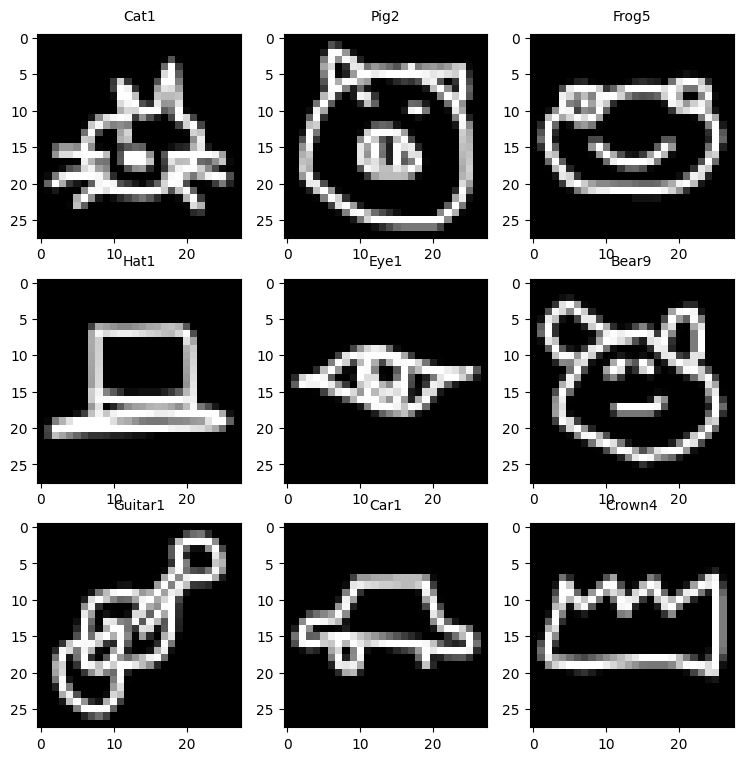

In [198]:
fig, axs = plt.subplots(3, 3, figsize=(9,9))

axs[0][0].imshow(cat1, cmap=plt.cm.gray)
axs[0][0].set_title("Cat1", fontsize=10, pad=10)

axs[0][1].imshow(pig2, cmap=plt.cm.gray)
axs[0][1].set_title("Pig2", fontsize=10, pad=10)

axs[0][2].imshow(frog5, cmap=plt.cm.gray)
axs[0][2].set_title("Frog5", fontsize=10, pad=10)

axs[1][0].imshow(hat1, cmap=plt.cm.gray)
axs[1][0].set_title("Hat1", fontsize=10, pad=10)

axs[1][1].imshow(eye1, cmap=plt.cm.gray)
axs[1][1].set_title("Eye1", fontsize=10, pad=10)

axs[1][2].imshow(bear9, cmap=plt.cm.gray)
axs[1][2].set_title("Bear9", fontsize=10, pad=10)

axs[2][0].imshow(guitar1, cmap=plt.cm.gray)
axs[2][0].set_title("Guitar1", fontsize=10, pad=10)

axs[2][1].imshow(car1, cmap=plt.cm.gray)
axs[2][1].set_title("Car1", fontsize=10, pad=10)

axs[2][2].imshow(crown4, cmap=plt.cm.gray)
axs[2][2].set_title("Crown4", fontsize=10, pad=10)


plt.show();

In [82]:
def compute_convolution(input_image, kernel):
    # Parameters
    kernel = np.array(kernel)
    kernel_height, kernel_width = kernel.shape

    img = np.squeeze(input_image) # Removes dimensions of size 1
    img_height, img_width = img.shape
    
    output_image = []

    for x in range(img_height - kernel_height + 1):
        arr = []
        
        for y in range(img_width - kernel_width + 1):
            
            a = np.multiply(img[x: x + kernel_height, y: y + kernel_width],
                            kernel)
            arr.append(a.sum())
            
        output_image.append(arr)
        
    return output_image

In [83]:
def plot_convolution(img, kernel, activation=False):
    ''' The following printing function ease the visualization'''
    
    img = np.squeeze(img)
    output_img = compute_convolution(img, kernel)
    if activation:
        output_img = np.maximum(output_img, 0)
    
    plt.figure(figsize=(10, 5))
    
    ax1 = plt.subplot2grid((3,3),(0,0), rowspan=3)
    ax1.imshow(img, cmap='gray')
    ax1.title.set_text('Input image')
    
    ax2 = plt.subplot2grid((3,3),(1, 1))
    ax2.imshow(kernel, cmap='gray')
    ax2.title.set_text('Kernel')    
    
    ax3 = plt.subplot2grid((3,3),(0, 2), rowspan=3)
    ax3.imshow(output_img, cmap='gray')
    ax3.title.set_text('Output image')    

    for ax in [ax1, ax2, ax3]:
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        
    plt.show()

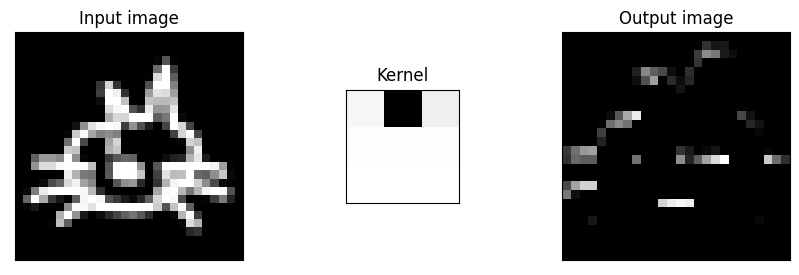

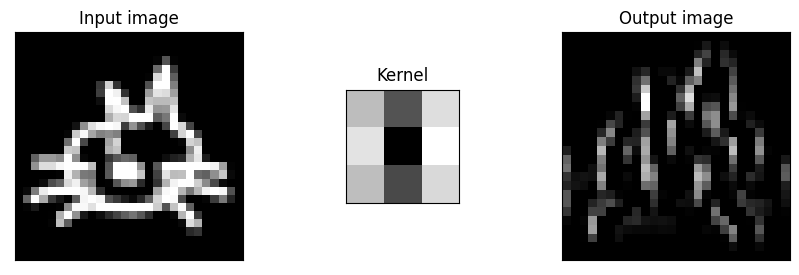

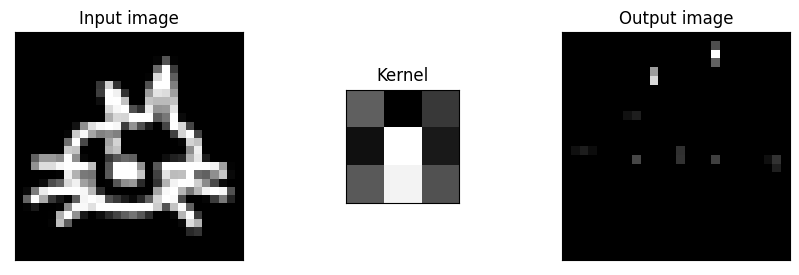

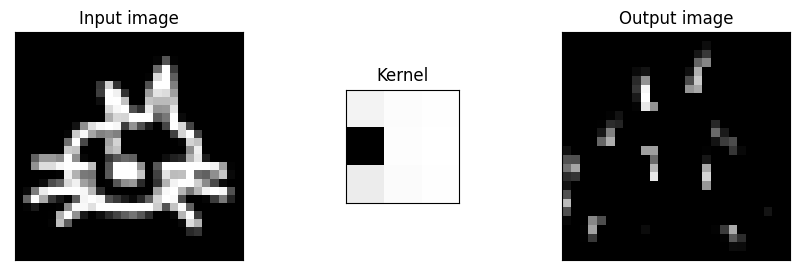

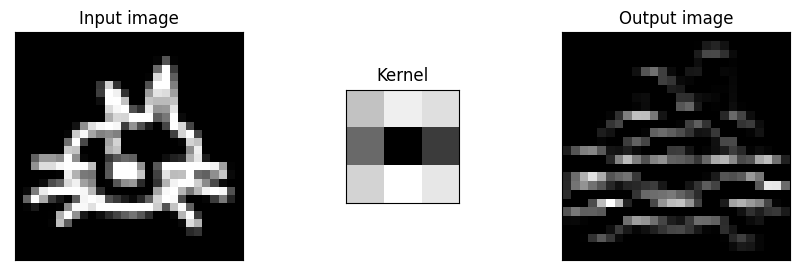

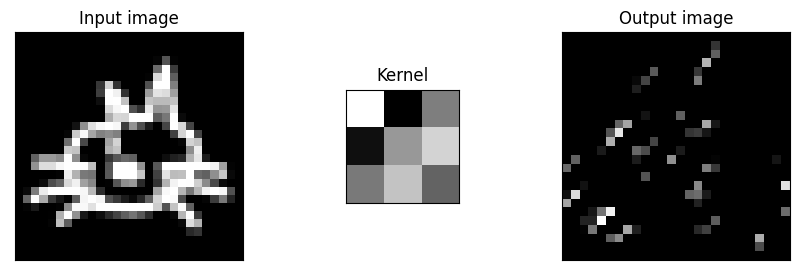

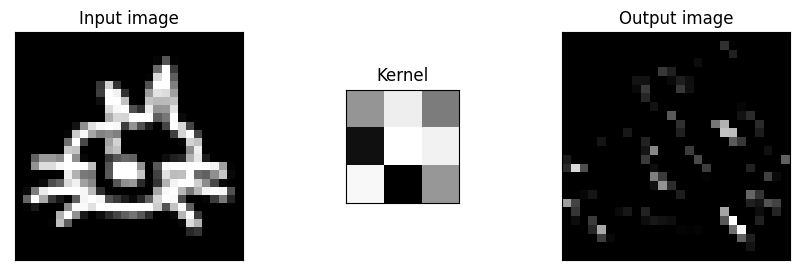

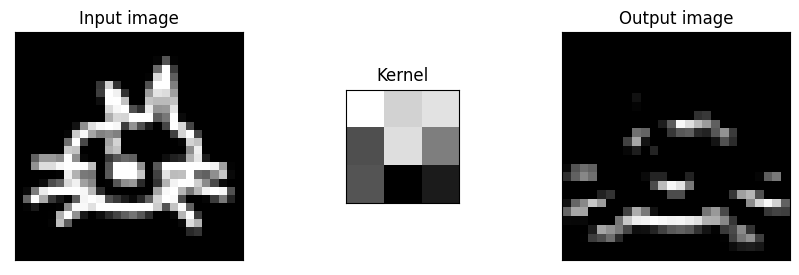

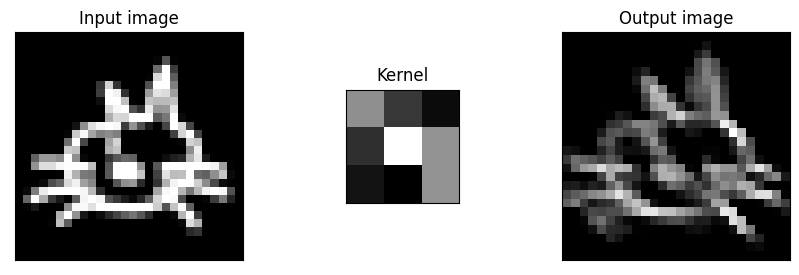

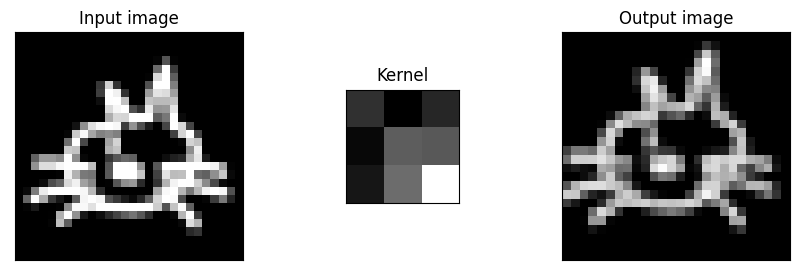

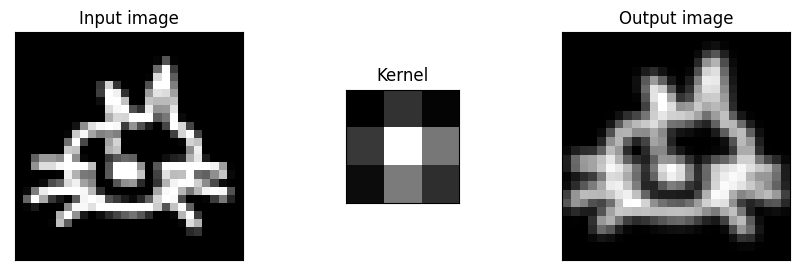

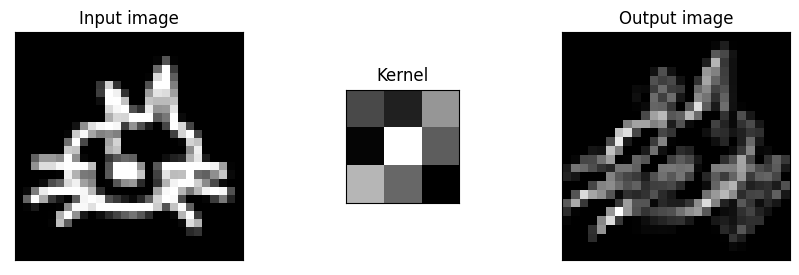

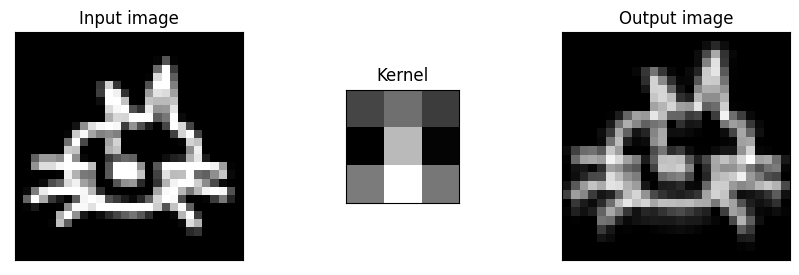

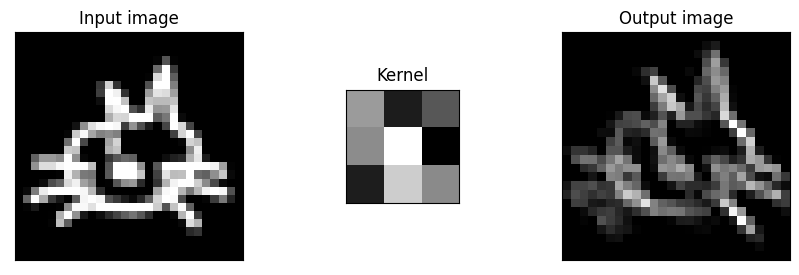

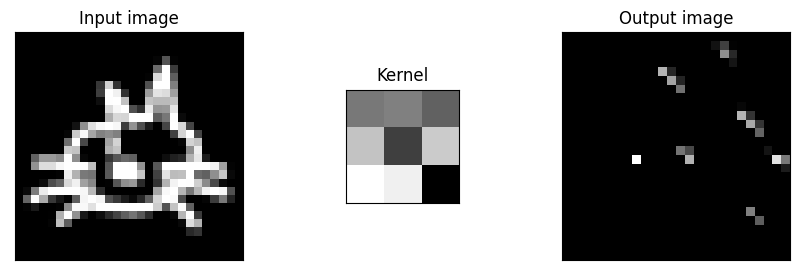

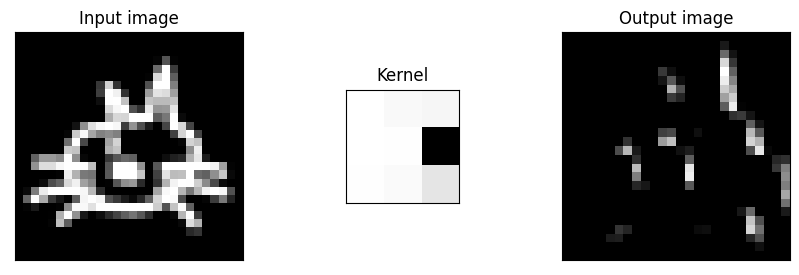

In [84]:
for i in range(0, 16):
    plot_convolution(cat1, first_convolution_layer.weights[0].numpy()[:,:,0,i], activation= True)

In [85]:
layers_outputs = [layer.output for layer in model.layers]
layers_outputs

[<KerasTensor: shape=(None, 26, 26, 16) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, 13, 13, 16) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 13, 13, 32) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 6, 6, 32) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 6, 6, 64) dtype=float32 (created by layer 'conv2d_2')>,
 <KerasTensor: shape=(None, 3, 3, 64) dtype=float32 (created by layer 'max_pooling2d_2')>,
 <KerasTensor: shape=(None, 576) dtype=float32 (created by layer 'flatten')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dense')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_1')>]

In [86]:
from tensorflow.keras import Model, models

activation_models = models.Model(inputs=model.input, outputs=layers_outputs)

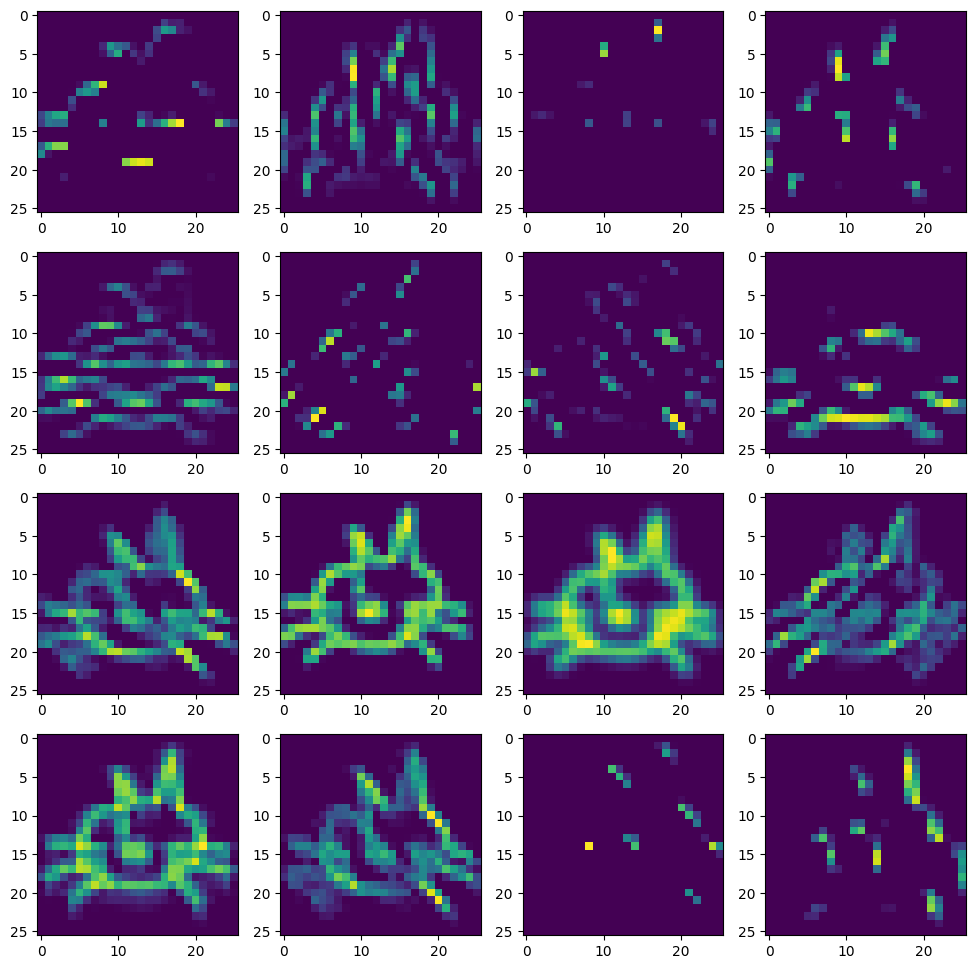

In [215]:
fig, axs = plt.subplots(4,4,figsize=(12,12))
axs = axs.ravel()

for i in range(first_convolution_layer.weights[0].shape[3]):
    axs[i].imshow(np.squeeze(activation_models.predict(cat1.reshape(1,28,28,1), verbose=0)[0])[:,:,i])
    
plt.show();

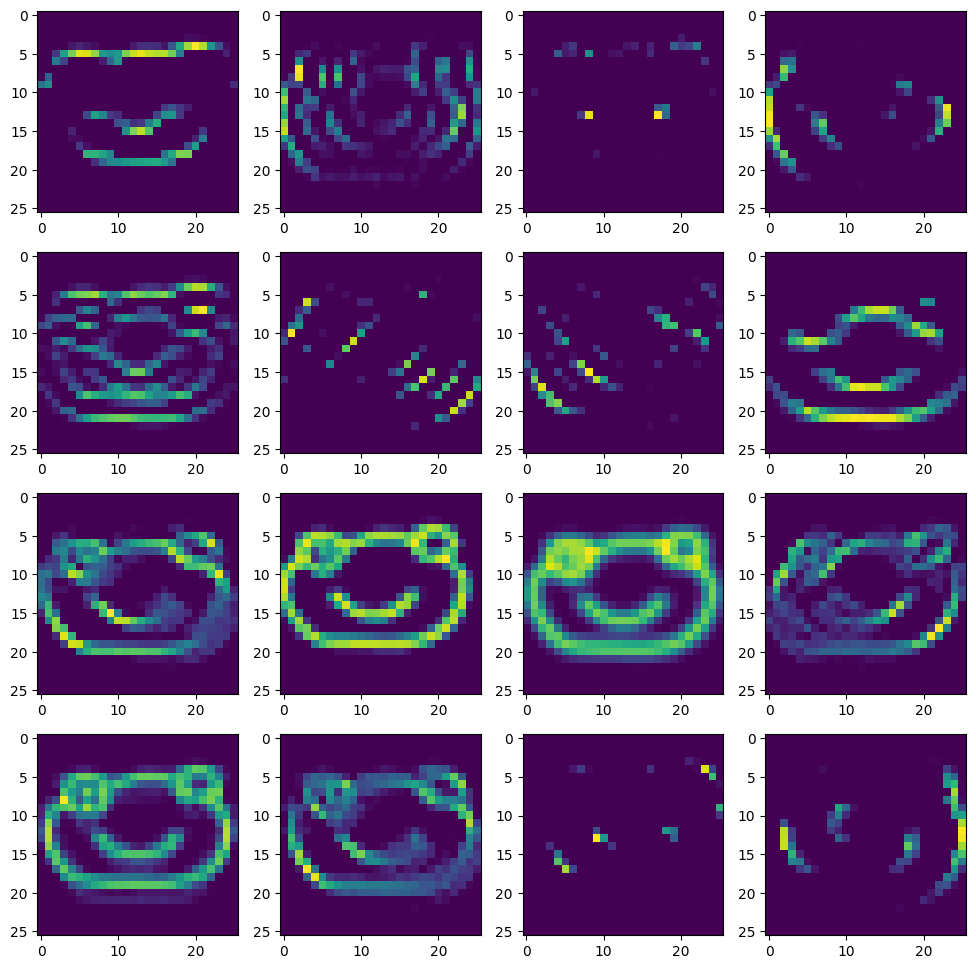

In [199]:
fig, axs = plt.subplots(4,4,figsize=(12,12))
axs = axs.ravel()

for i in range(first_convolution_layer.weights[0].shape[3]):
    axs[i].imshow(np.squeeze(activation_models.predict(frog5.reshape(1,28,28,1), verbose=0)[0])[:,:,i])
    
plt.show();

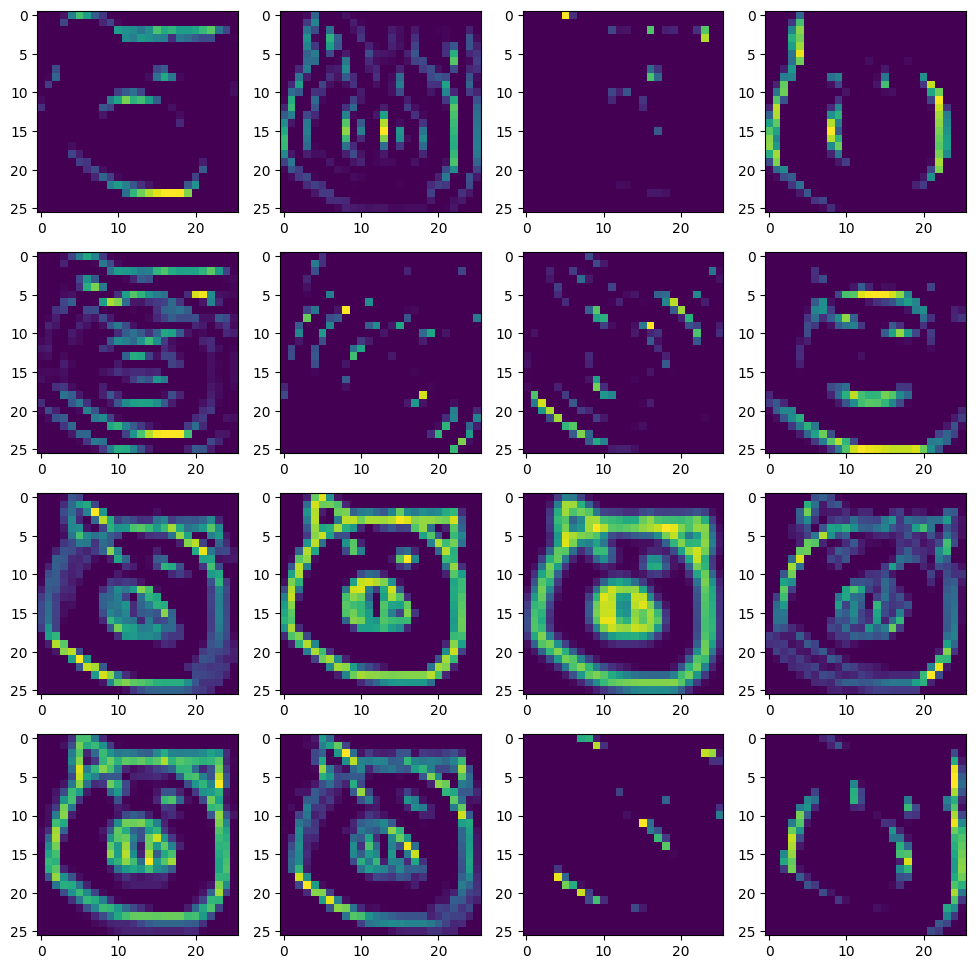

In [139]:
fig, axs = plt.subplots(4,4,figsize=(12,12))
axs = axs.ravel()
for i in range(first_convolution_layer.weights[0].shape[3]):
    axs[i].imshow(np.squeeze(activation_models.predict(pig2.reshape(1,28,28,1), verbose=0)[0])[:,:,i])
    
plt.show();

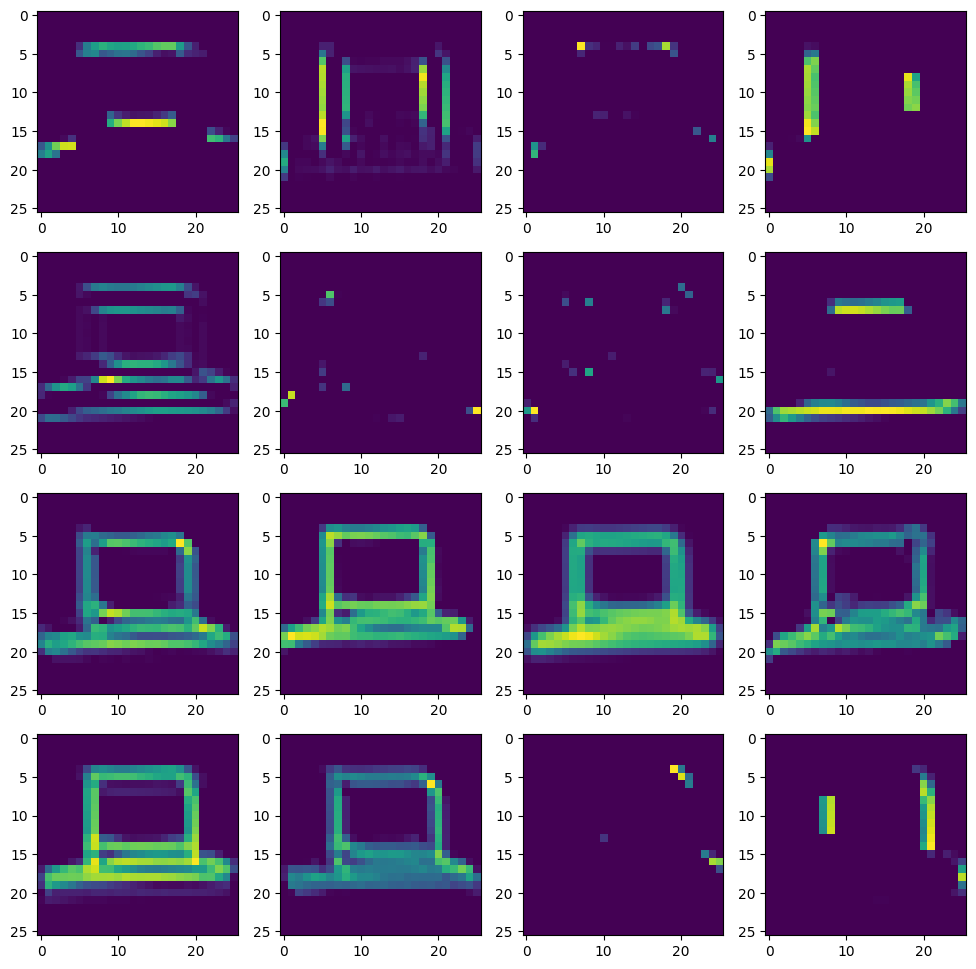

In [200]:
fig, axs = plt.subplots(4,4,figsize=(12,12))
axs = axs.ravel()

for i in range(first_convolution_layer.weights[0].shape[3]):
    axs[i].imshow(np.squeeze(activation_models.predict(hat1.reshape(1,28,28,1), verbose=0)[0])[:,:,i])
    
plt.show();

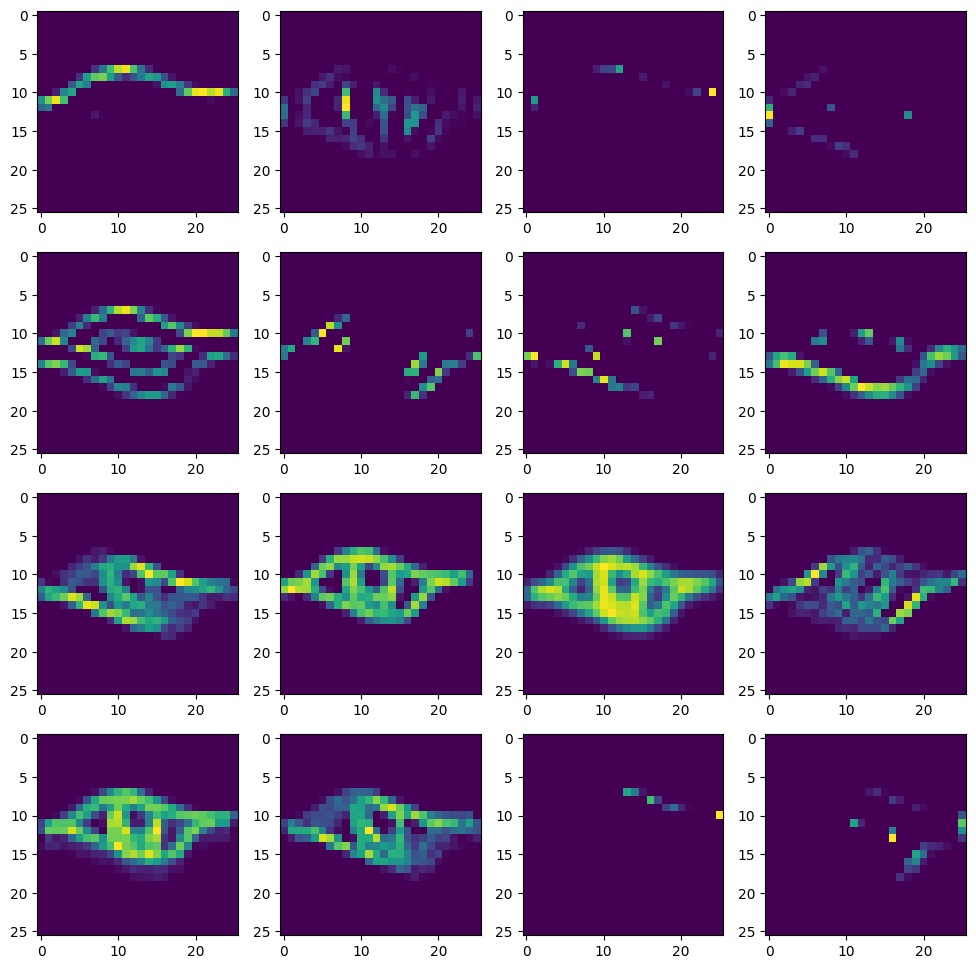

In [201]:
fig, axs = plt.subplots(4,4,figsize=(12,12))
axs = axs.ravel()

for i in range(first_convolution_layer.weights[0].shape[3]):
    axs[i].imshow(np.squeeze(activation_models.predict(eye1.reshape(1,28,28,1), verbose=0)[0])[:,:,i])
    
plt.show();

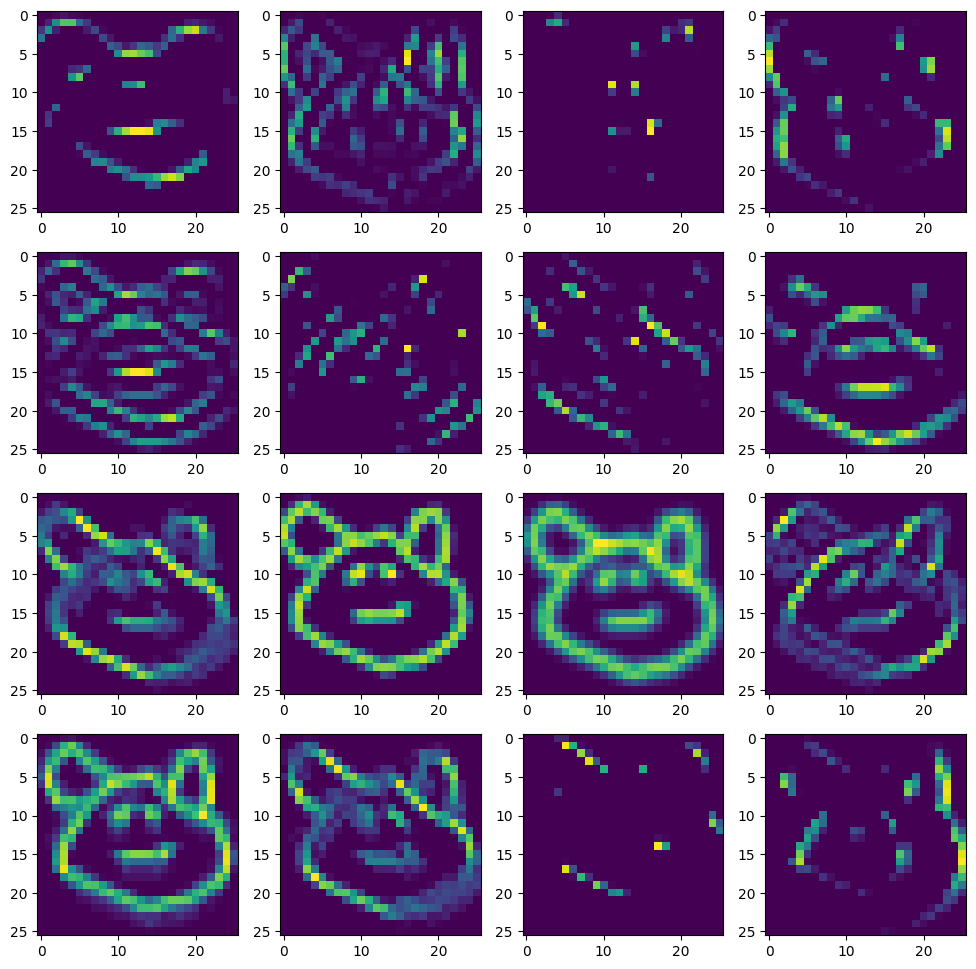

In [202]:
fig, axs = plt.subplots(4,4,figsize=(12,12))
axs = axs.ravel()

for i in range(first_convolution_layer.weights[0].shape[3]):
    axs[i].imshow(np.squeeze(activation_models.predict(bear9.reshape(1,28,28,1), verbose=0)[0])[:,:,i])
    
plt.show();

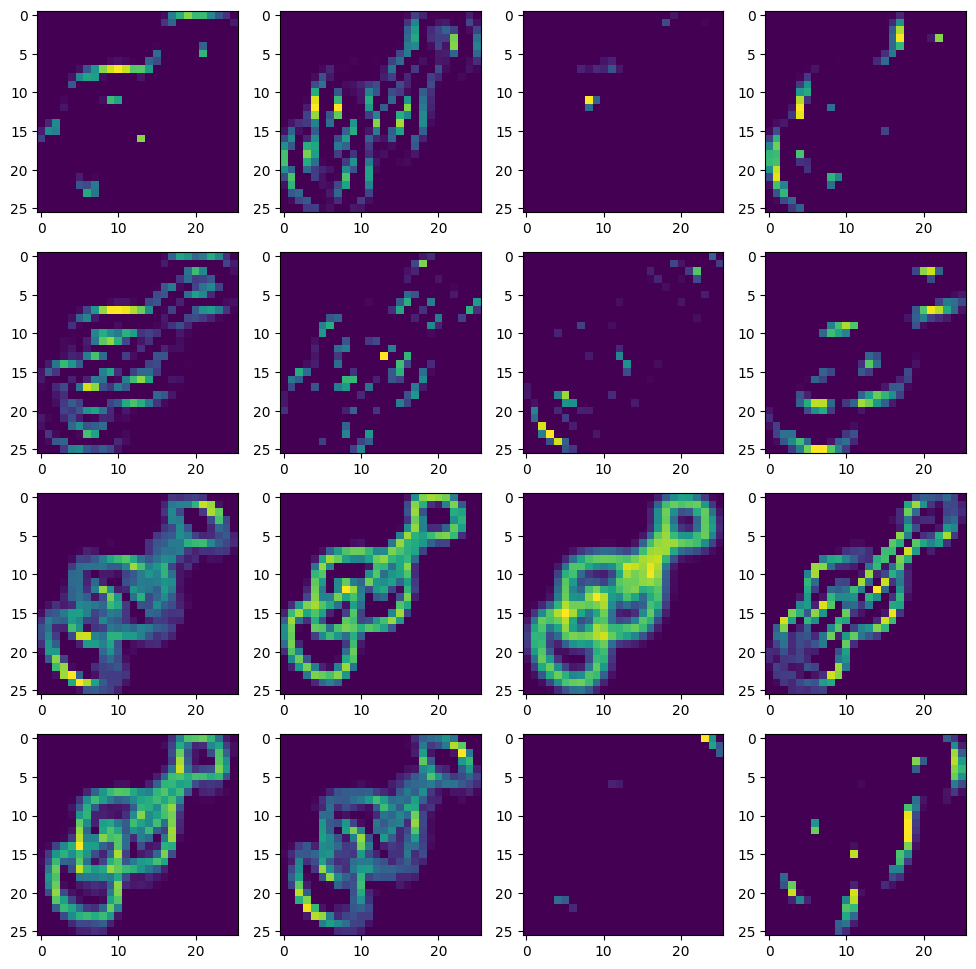

In [203]:
fig, axs = plt.subplots(4,4,figsize=(12,12))
axs = axs.ravel()

for i in range(first_convolution_layer.weights[0].shape[3]):
    axs[i].imshow(np.squeeze(activation_models.predict(guitar1.reshape(1,28,28,1), verbose=0)[0])[:,:,i])
    
plt.show();

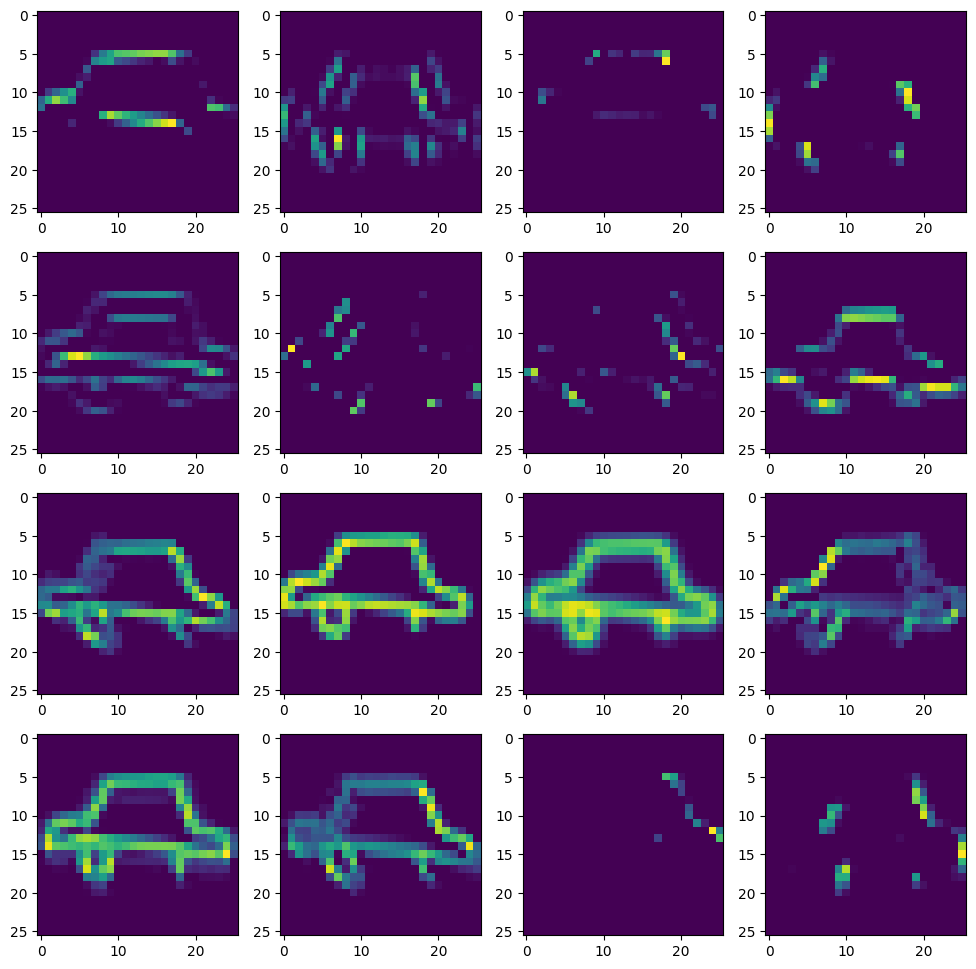

In [204]:
fig, axs = plt.subplots(4,4,figsize=(12,12))
axs = axs.ravel()

for i in range(first_convolution_layer.weights[0].shape[3]):
    axs[i].imshow(np.squeeze(activation_models.predict(car1.reshape(1,28,28,1), verbose=0)[0])[:,:,i])
    
plt.show();

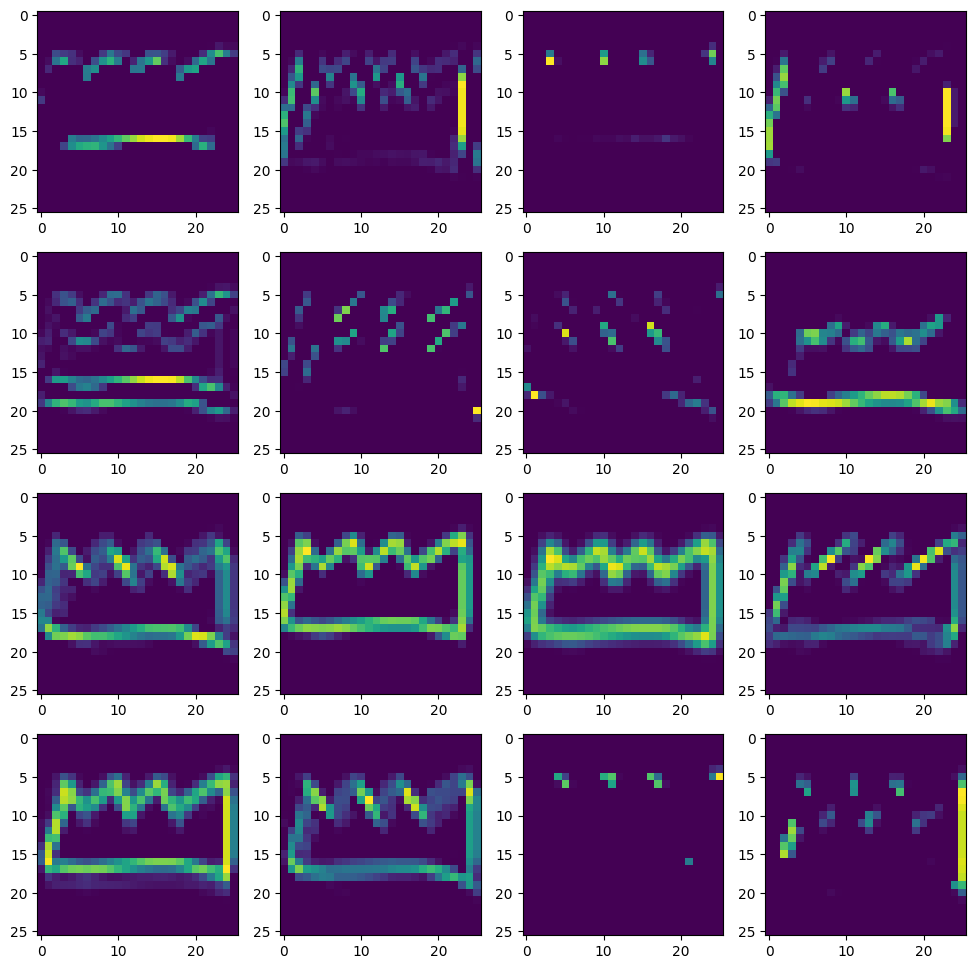

In [205]:
fig, axs = plt.subplots(4,4,figsize=(12,12))
axs = axs.ravel()

for i in range(first_convolution_layer.weights[0].shape[3]):
    axs[i].imshow(np.squeeze(activation_models.predict(crown4.reshape(1,28,28,1), verbose=0)[0])[:,:,i])
    
plt.show();

In [106]:
second_convolution_layer.weights[0].shape[3]

32

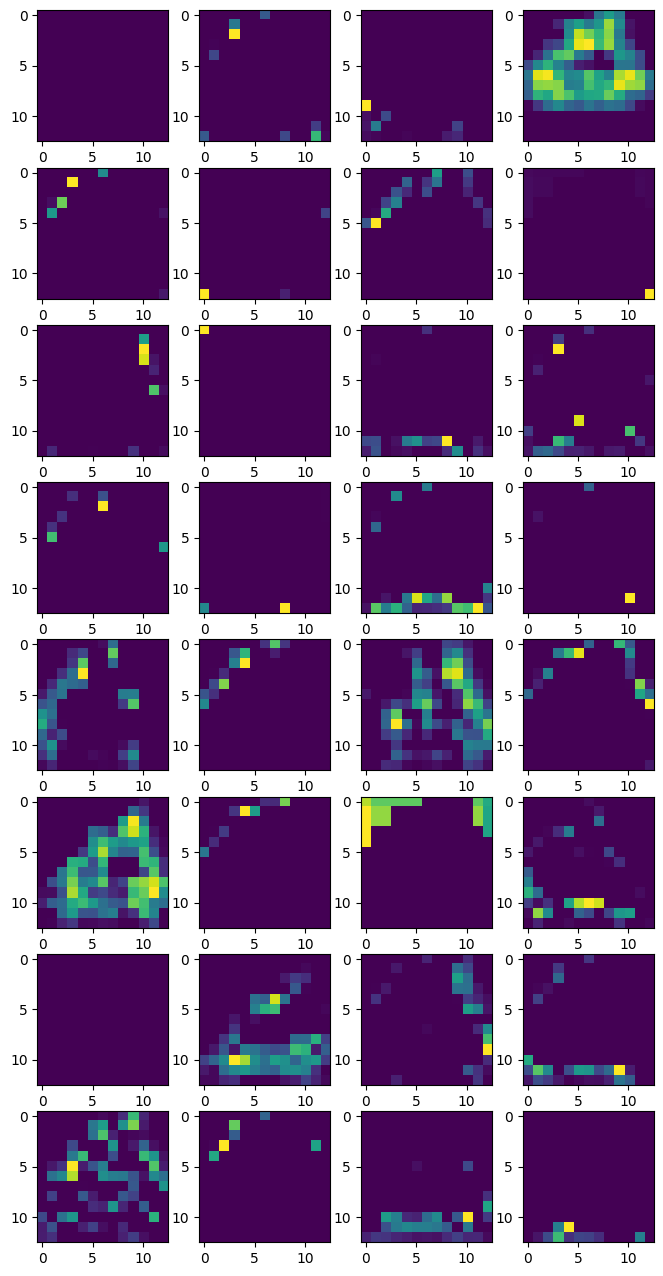

In [120]:
fig, axs = plt.subplots(8,4,figsize=(8,16))
axs = axs.ravel()
for i in range(second_convolution_layer.weights[0].shape[3]):
    axs[i].imshow(np.squeeze(activation_models.predict(cat1.reshape(1,28,28,1), verbose=0)[2])[:,:,i])

plt.show();

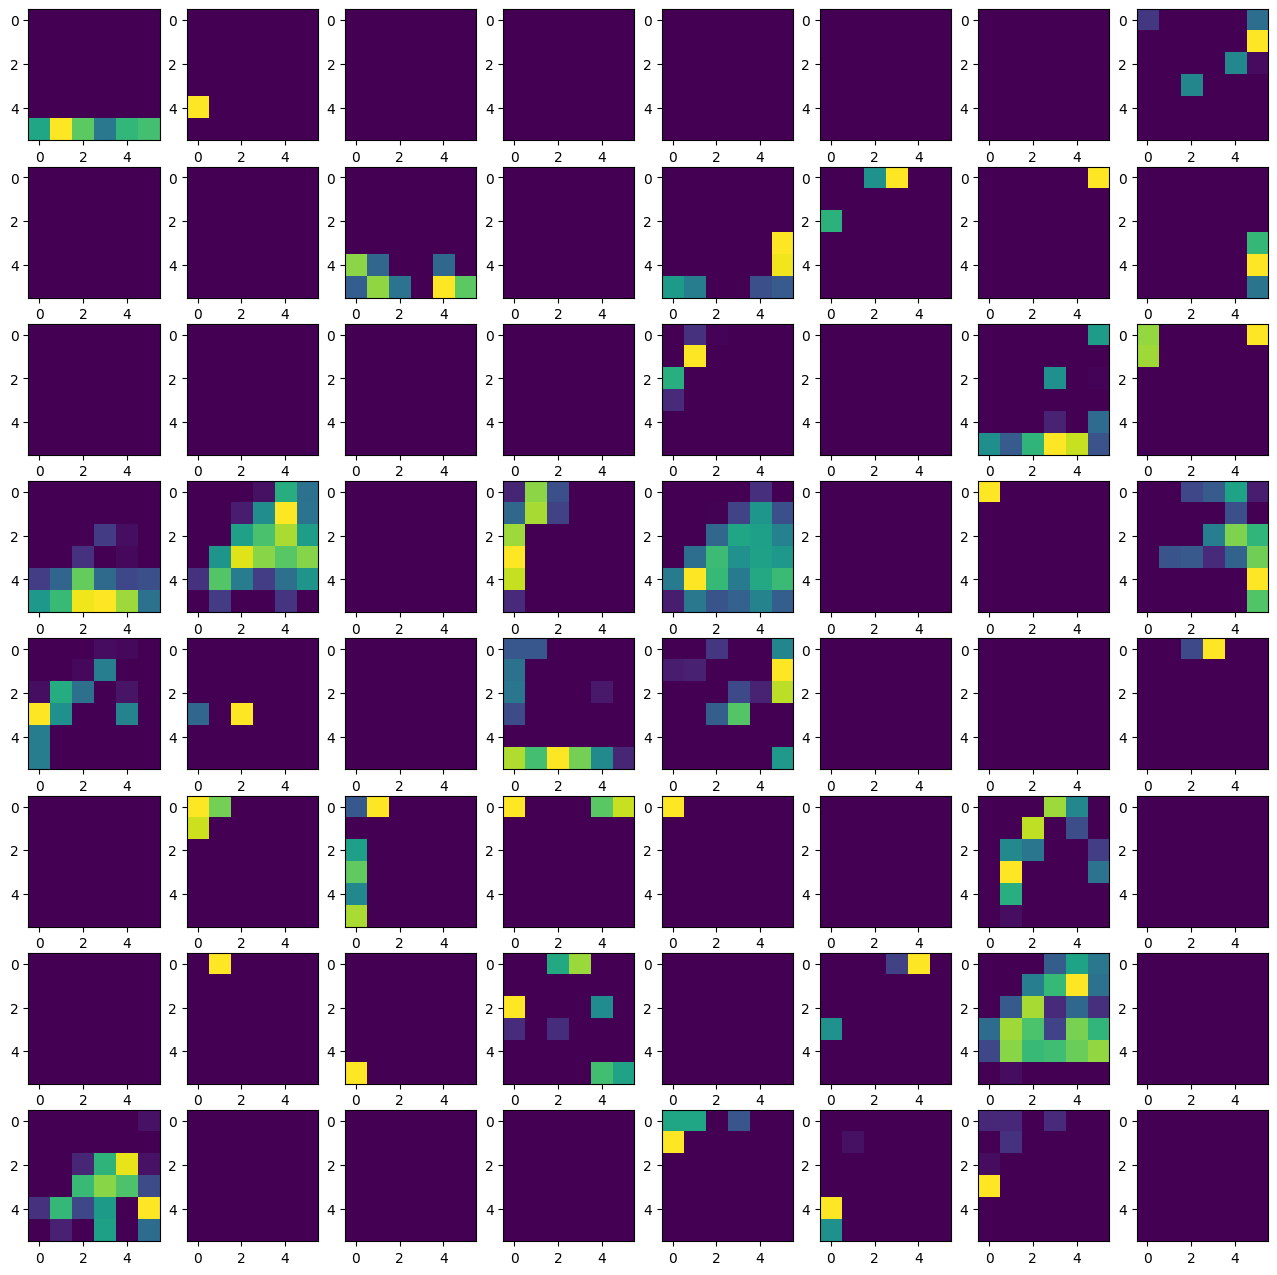

In [124]:
fig, axs = plt.subplots(8,8,figsize=(16,16))
axs = axs.ravel()
for i in range(third_convolution_layer.weights[0].shape[3]):
    axs[i].imshow(np.squeeze(activation_models.predict(cat1.reshape(1,28,28,1), verbose=0)[4])[:,:,i])

plt.show();

# RNN - load model & build classification report

## Load model and data

In [42]:
import time

In [47]:
def load_rnn_model():
    """
    load the latest saved model, return None if no model found
    """
    stage = "Production"
    model = None
    mlflow.set_tracking_uri('https://mlflow.lewagon.ai')
    model_uri = f"models:/{'deepdraw-model-rnn'}/{stage}"
    model = mlflow.keras.load_model(model_uri=model_uri)
    return model

In [48]:
rnn_model = load_rnn_model()
rnn_model.summary()

2022-12-06 11:57:33.263703: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-06 11:57:38.619482: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-06 11:57:38.929460: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-06 11:57:40.655222: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-06 11:57:41.115748: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _ou

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 1920, 3)           0         
                                                                 
 lstm (LSTM)                 (None, 1920, 20)          1920      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                                 
 dense (Dense)               (None, 50)                1050      
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
Total params: 8,800
Trainable params: 8,800
Non-trainable params: 0
_________________________________________________________________


In [52]:
#Don't forget to change the local path of the user
rnn_path_yaml= "/Users/jean-baptiste/code/Sythak/deepdraw/deep_draw/dl_logic/categories_rnn_50.yaml"

# Open the file and load the file
with open(rnn_path_yaml) as f:
    rnn_class_names = yaml.load(f, Loader=SafeLoader)

In [53]:
def parse_tfexample_fn2(element):
    """Parse a single record which is expected to be a tensorflow.Example."""
    feature_to_type = {
        "ink": tf.io.FixedLenFeature([], dtype=tf.string),
        "height": tf.io.FixedLenFeature([], dtype=tf.int64),
        "width": tf.io.FixedLenFeature([], dtype=tf.int64),
        "class_index" : tf.io.FixedLenFeature([], dtype=tf.int64)
    }

    content = tf.io.parse_single_example(element, feature_to_type)
    height = content["height"]
    width = content["width"]
    label= content["class_index"]
    raw_image = content["ink"]
    feature = tf.io.parse_tensor(raw_image, out_type=tf.double)
    feature = tf.reshape(feature, shape=[height,width])

    return (feature, label)

In [54]:
def get_dataset_multi(tfr_dir: str = "/content/", pattern: str = "*.tfrecords"):
    files = glob.glob(os.path.join(tfr_dir, pattern), recursive=False)
    #print(files)

    #create the dataset
    dataset = tf.data.TFRecordDataset(files)

    #pass every single feature through our mapping function
    dataset = dataset.map(parse_tfexample_fn2)
    return dataset

def load_tfrecords_dataset(source_type = 'test', batch_size=32):
    dataset = get_dataset_multi(tfr_dir='../raw_data/tfrecords/', pattern=f"*_{source_type}.tfrecords")
    dataset = dataset.batch(batch_size)
    return dataset

In [56]:
#Initialize dataset-test
dataset_test = load_tfrecords_dataset(source_type = 'test', batch_size=32)

In [55]:
y_pred = rnn_model.predict(dataset_test)
print(f"shape of y_pred : {y_pred.shape}")

NameError: name 'dataset_test' is not defined

In [ ]:
y_pred

In [ ]:
class Estimator:
    _estimator_type = ''
    classes_=[]
    def __init__(self, model, classes):
        self.model = model
        self._estimator_type = 'classifier'
        self.classes_ = classes
    def predict(self, X):
        y_prob= self.model.predict(X)
        y_pred = y_prob.argmax(axis=1)
        return y_pred

#define classifier rnn
rnn_classifier = Estimator(rnn_model, rnn_class_names)

In [ ]:
y = np.concatenate([y for x, y in dataset_test], axis=0)
x = np.concatenate([x for x, y in dataset_test], axis=0)

In [ ]:
#test content x, y
print(x)
print(y)

In [ ]:
pred_y = np.argmax(y_pred, 1)

In [ ]:
#test content pred_y
pred_y

## RNN confusion matrix and classification report

In [ ]:
#plot confusion matrix

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(estimator= rnn_classifier, X=x, y_true=y, cmap='Blues',normalize='true', include_values=False, ax=ax)
plt.title('Confusion matrix')
plt.tick_params(left = False)
plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)

In [ ]:
#print RNN classification report

print(classification_report(y, pred_y, target_names = rnn_class_names))